## Back and Forth nudging method with the Lorenz 63 system

### Illustration of the experimental approach

This approach consists in performing twin experiments with simulated data.
First, a reference experiment is run and the corresponding data are extracted. From now on this reference trajectory will 
be called the exact referernce solution. Experimental data are supposed to be obtained every nx gridpoints of the model, and every freq time steps. The simulated data are then optionally noised, and provided as observations to the assimilation scheme.Finally, the results of the assimilation process are compared with the exact solution.

### Import Libraries 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pc

### Definition of Lorenz model equations

Lorenz differentail equations system is :
    
$$\dot{x}=10(y-x) $$
$$\dot{y}={x}(28-z)-y $$
$$\dot{z}=xy- 8/3{z}$$

In [19]:

class Model:

    def __init__( self, nmembers = 1 ):
        self.nmembers = nmembers
        self.nx = 3                             # number of variables (Lorenz 63)
        self.dt = 0.01                          # length of step
        self.time = 0.
        self.x0 = np.array([1.5, -1.5, 20.])    #initial conditions 
        self.xvar = self.initial_condition() 
        self.xvar_series = []
        self.time_series = []
        self.k_nudging = 0.
        self.day_interval = self.dt/2.
        self.obs_filename = 'ref_data.pkl'
        self.obs_v='x'
       
        
    def initial_condition(self):
        "This function is just to reshape the initial condition array"
        if self.nmembers == 1:
             xout = self.x0.reshape((self.nx, 1))
        return xout

    def rhs(self,xvar):
        "Computes the right hand side of lorenz differential equation"   
        x_out=np.zeros_like(xvar)
        x_out[0,]=10*(xvar[1,]-xvar[0,])
        x_out[1,]=28*xvar[0,]-xvar[1,]-xvar[0,]*xvar[2,]
        x_out[2,]=xvar[0,]*xvar[1,]-(8/3)*xvar[2,]
        return x_out

    def euler (self, integr_func):
        """update variables with euler steps.
           integr_function is the RHS term of the equation."""        
        self.xvar +=integr_func(self.xvar)*self.dt
  
    def nudging_coefficient (self,day,obsday):
        "This function returns the nudgig coefficient"
        a = obsday-day
        a = 1. - np.sign(a)*a/np.float(self.day_interval)
        a = np.maximum(a,0.)
        return self.k_nudging*a
   
    def nudging_term(self, xvar) :
        "Compute the nudging term using available observations"
        nudg_out = np.zeros_like(xvar)        
        day =self.time 
        check_obs, obs_days,obs_val1,obs_val2,obs_val3 = self.observation(day)      # get obs. days and values for the day
        if check_obs == True:
            nobs = len(obs_days)
            
            for io in range(nobs):
                obsday = obs_days[io]
                obsval1=obs_val1[io]
                obsval2=obs_val2[io]
                obsval3=obs_val3[io]
                
                if self.obs_v =='x':
                    nudg_out[0,] += self.nudging_coefficient(day, obsday)*(obsval1-self.xvar[0,]) 
                if self.obs_v =='y':
                    nudg_out[1,] += self.nudging_coefficient(day, obsday)*(obsval1-self.xvar[1,])
                if self.obs_v =='z':
                    nudg_out[2,] += self.nudging_coefficient(day, obsday)*(obsval3-self.xvar[2,])
                if self.obs_v=='xyz':
                    nudg_out[0,] += self.nudging_coefficient(day, obsday)*(obsval1-self.xvar[0,]) 
                    nudg_out[1,] += self.nudging_coefficient(day, obsday)*(obsval2-self.xvar[1,])
                    nudg_out[2,] += self.nudging_coefficient(day, obsday)*(obsval3-self.xvar[2,])
                
        return nudg_out
        
    def rhs_with_nudging(self,xvar):
        "Returns RHS with the nudging term"
        return self.rhs(xvar) + self.nudging_term(xvar)
    
    def run(self, days, mode='free', k_nudging=0.2, day_interval=0.2, obs_file=None,obs_variable='x'):
        """Run themodel time integration with or without data assimilation 
        ----------
        Parameters:
        ----------
        days: number of days of integration
        mode: 'free' (default) or 'nudging'.
        k_nudging: nudging coefficient. Default: 0.2
        day_interval: time lag around observation time, over which nudging is applied. Default: 20
        obs_file:name of file where observations are saved """
        
        nsteps = int(days/self.dt)     
        self.xvar_series = np.zeros((3, nsteps+1, self.nmembers))
        self.xvar_series[:,0,:] = self.xvar
        self.time_series = np.empty(nsteps+1)
        self.time_series[0] = self.time
        self.k_nudging = k_nudging
        self.day_interval = day_interval
        
        if obs_file is not None:
            self.obs_filename = obs_file
        
        if obs_variable != 'x':
            self.obs_v = obs_variable
        
        
        for it in range(nsteps):
            self.time += self.dt
            
            if mode == 'nudging':
                self.euler(self.rhs_with_nudging)
            else:
                self.euler(self.rhs)
            self.xvar_series[:,it+1,:] = self.xvar
            self.time_series[it+1] = self.time
              
    def save_obs(self, filename=None, freq=25,obs_variable='xyz'):
        """ freq is time steps of saving variable""" 
        
        if filename is not None:
            self.obs_filename = filename
        ntim = np.shape(self.xvar_series)[1] # size of series
        ref={'x':self.xvar_series[0,np.arange(freq, ntim, freq), 0],'y':self.xvar_series[1,np.arange(freq, ntim, freq), 0],'z':self.xvar_series[2,np.arange(freq, ntim, freq),0]} 
        #print(self.xvar_series[0,np.arange(freq, ntim, freq), 0].shape)
        refvalue={k:v.tolist() for k,v in ref.items()} # converting in to list
        reftime=self.time_series[np.arange(freq, ntim, freq)].tolist()
        pc.dump((refvalue,reftime),open (self.obs_filename,"wb")) # write dictionary into file
        
    
    
    def read_obs(self):
        try:
            (x,t)=pc.load(open (self.obs_filename,"rb"))
        except:
            print('Missing obs file')
            
        day_list=t
        obs_val=x
        return day_list, obs_val
            
        
    def observation(self, day):
        """Check if observations are available for the 3 variables, and get the values."""
        day_list, obs_val = self.read_obs()
        check = False
        obsday = []
        obsval1 = []
        obsval2 = []
        obsval3 = []
        global_check= False
    
        for day_tmp in day_list:
            s=np.arange(day-self.day_interval, day+self.day_interval, self.dt) # range of days 
            r=(np.abs(s-day_tmp)<self.dt*0.25) # check if day exist in range (returns boolean)
            check=any(r)
            if check ==True :
                    global_check = True
                    obsday = obsday + [day_tmp]
                    io = day_list.index(day_tmp)
                    
                    obsval1=obsval1+[obs_val['x'][io]]
                    obsval2=obsval2+[obs_val['y'][io]]
                    obsval3=obsval3+[obs_val['z'][io]]
                    #obsval11=self.rotatelist(obsval1,50)
                    #print (obsval1,obsval11)
                   
        return global_check, obsday, obsval1,obsval2,obsval3
    
    def rotatelist(self,l,k): 
        n = len(l) 
        if k < 0: 
            return l 
        while(k>0): 
            temp=l[0] 
            for i in range(n-1):
                l[i]=l[i+1] 
                l[i+1]=temp 
                k=k-1 
                return l
            
    def RMSE(self, day_start, day_end, ref_state = None):
        """ Compute the Root Mean Squre Error of variables
        (this error is important for the performance of the model)
        ----------
        Parameters:
        ----------
        day_start: aday to start the calculation of RMSE
        day_end: a day to end the computation 
        ref_state: a reference by which we want to compute RMSE 
        ind_start,ind_end:indecises of starting and ending day in time_series"""
        
        ind_start= np.where(np.abs(self.time_series - day_start) < 0.0001)[0][0]   # index of starting day
        ind_end= np.where(np.abs(self.time_series - day_end) < 0.0001)[0][0]       # index of ending day 
        mse1 = 0
        for it in range(ind_start, ind_end): #looping over the time 
            for ie in range(self.nmembers):  #looping over the numbers 
                mse1 += (self.xvar_series[0,it,ie] - ref_state[0,it,ie])**2  # compute RMSE
                
        nsteps = ind_end-ind_start
        if nsteps is not 0:
            mse1 /= nsteps*self.nmembers
            mse1 = np.sqrt(mse1)
        return mse1
    
    def plot(self):
        plt.figure(figsize=(12,8))
        for ix in range(self.nx):
            pnum = str(311+ix)
            plt.subplot(pnum)
            for ie in range(self.nmembers):
                plt.plot(self.time_series[:],self.xvar_series[ix,:,ie],'black',linewidth=1.)
        plt.show()
        
        

## Data Without assimilation

Here two data curves are obtained:

1) Reference data with the given initial conditions (1.5, -1.5, 21), which we consider to be true. 

2) Another data with unperfect initial conditions (3, -3, 21), which we consider it wrong data.

Later on the data with unperfect initial conditions will be assimilated using nudging.   

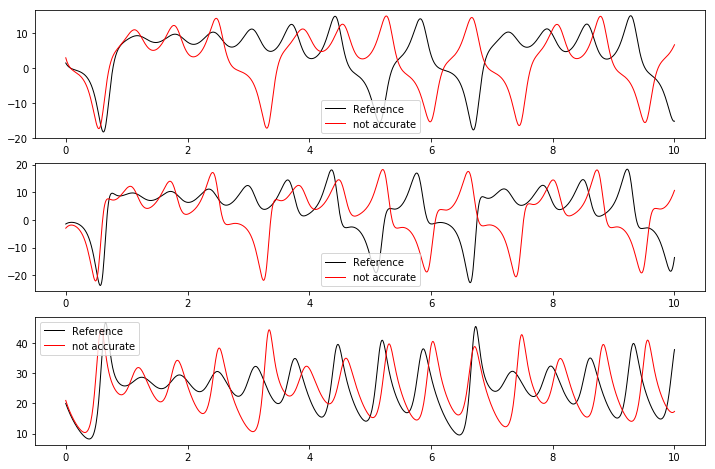

In [20]:
ntime=10
lorenz_ref = Model()
lorenz_ref.run(ntime)
lorenz_ref.save_obs(filename='obs012_10.pkl',freq=10)
true_state = lorenz_ref.xvar_series
true_time = lorenz_ref.time_series
wrong_state = np.array([3., -3., 21.])
lorenz_test1 = Model()
lorenz_test1.x0 = np.copy(wrong_state)
lorenz_test1.xvar = lorenz_test1.initial_condition()
lorenz_test1.run(ntime)
plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = str(311+ix)
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(lorenz_test1.time_series,lorenz_test1.xvar_series[ix,:,0],'red',linewidth=1.,label='not accurate')
    plt.legend(loc='best')
plt.show()


### Reading data

Here we assume that we have observations of the three variables $x$,$y$,$z$ 

In [21]:
(r,t)=pc.load(open ('obs012_10.pkl',"rb")) # just to be sure that observations are read 

In [22]:
print(r)

{'x': [-0.15687348804737097, -0.7692997765319508, -1.7379041434437643, -4.103507028673404, -9.76867970497334, -17.904102311641118, -10.32950587029136, 2.2761434220197243, 6.536783314218826, 8.103346359806473, 9.081255320433263, 9.322962694884824, 8.611615435823612, 7.672282352251979, 7.404235641568091, 8.052453185888497, 9.194933358120004, 9.781756211609892, 8.958151454290224, 7.511112783206449, 6.860146701342143, 7.48347632794921, 9.04561987660351, 10.327366727468648, 9.619884790800727, 7.461732282375703, 6.138133917307309, 6.511330167420266, 8.375854676803494, 10.723974911086426, 10.852062020749173, 7.856138989710673, 5.304568384131661, 4.9631624822634866, 6.593274067854065, 9.876261070630369, 12.579582091663433, 9.933694232164669, 4.99786903908897, 2.875478692156702, 3.1186287683587217, 5.12283258083585, 9.426071730755472, 14.575526998793247, 11.268768892558382, 2.939166492819932, -0.714027331237924, -2.1498500881358953, -3.974337813848785, -7.753197481660888, -13.824999594224156, -

## Data Assimilation 

We now turn to data assimilation. We assume our model is inaccurate, and the initial condition is not perfectly known. To mimic this, we assimilate observations extracted from the reference simulation initial condition (1.5, -1.5, 21) into an unperfect model initialized with unperfect conditions (3, -3, 21).

To make the experiment even closer to reality, we will consider observations of the three variable $x$,$y$,and $z$

### Nudging Method 

Nudging consists in replacing the original model equation:
$$ \frac{dX}{dt} = f(X,t) $$
by the following equation:
$$ \frac{dX}{dt} = f(X,t) + K (X_{obs}(t) - X(t) )$$

where $X_{obs}(t)$ is the observation values of $X(t)$ and $K$ is a nudging coefficient. Note that:

- In absence of observation, the nudging term does not appear and the the original equation is retrieved;
- Nudging at the single time of observation (i.e., once in the simulation) has little impact. Usually, the nudging term is activated some time before the observation time, with $K$ increasing from 0 to its prescribed value, then nudging is progressively deactivated by decreasing $K$ to 0.


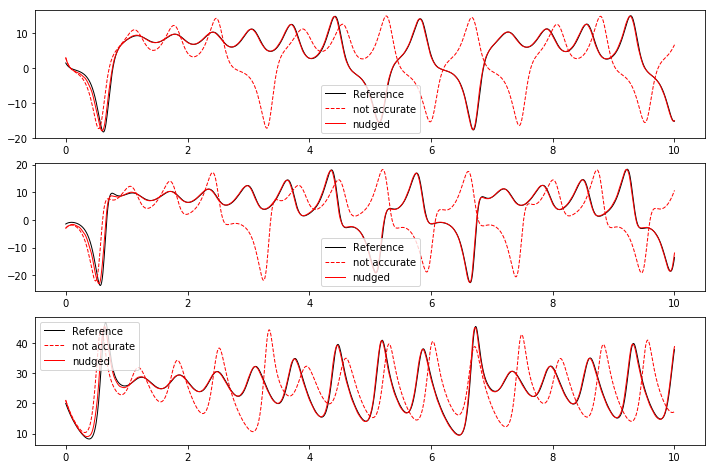

In [23]:
lorenz_assim1 = Model()
lorenz_assim1.x0 = np.copy(wrong_state)
lorenz_assim1.xvar = lorenz_assim1.initial_condition()
ntime = 10
lorenz_assim1.run(ntime, mode = 'nudging', k_nudging = 10, day_interval = 0.04, obs_file='obs012_10.pkl',obs_variable='xyz')
plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = str(311+ix)
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(lorenz_test1.time_series,lorenz_test1.xvar_series[ix,:,0],'red', linestyle='dashed',linewidth=1.,label='not accurate')
    plt.plot(lorenz_assim1.time_series,lorenz_assim1.xvar_series[ix,:,0],'red',linewidth=1.,label='nudged')
    plt.legend(loc='best')
plt.show()


In [35]:
ntime =5 # day
nfreqmax = 3 #50 # number of frequency time steps
nudging_k_list = np.arange(0,6,1)# (0,51,1)nudging coefficient list
nb_nudg = len(nudging_k_list)
day_start, day_end = 1, 5
rmse1 = np.empty((nfreqmax, nb_nudg))#(50,50)

for ifreq in range(0,nfreqmax):
    # Prepare true trajecory and obs
    lorenz_ref = Model()
    lorenz_ref.run(ntime)
    lorenz_ref.save_obs(filename='obs012_'+str(ifreq+1)+'.pkl',freq=ifreq+1)
    true_state = lorenz_ref.xvar_series
    true_time = lorenz_ref.time_series
          
    # Loop nudging coefficient
    for inudg in range(nb_nudg):
        lorenz_assim1 = Model()
        wrong_state = np.array([3., -3., 21.])
        lorenz_assim1.x0 = np.copy(wrong_state)
        lorenz_assim1.xvar = lorenz_assim1.initial_condition()
        # run nudging
        lorenz_assim1.run(ntime, mode = 'nudging', k_nudging = nudging_k_list[inudg], day_interval = 0.04, obs_file='obs012_'+str(ifreq+1)+'.pkl',obs_variable='xyz')
        rmse1[ifreq, inudg] = lorenz_assim1.RMSE(day_start, day_end, ref_state = true_state)
        
print(rmse1)    
        

[[7.372506   0.27387532 0.26742371 0.26775878 0.26840273 0.26890909]
 [7.372506   0.32406918 0.27392967 0.26846675 0.26750313 0.26756381]
 [7.372506   0.40067217 0.29296388 0.27389257 0.26930815 0.26780111]]


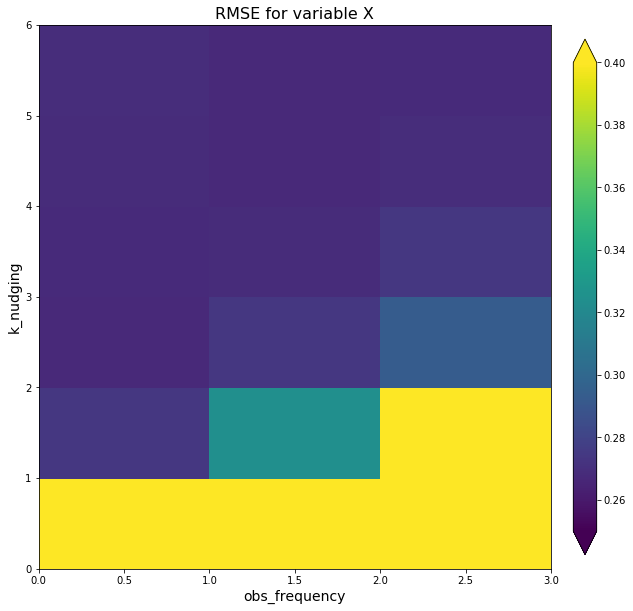

In [27]:
plt.figure(figsize=(10, 10))
vmin=0.25
vmax=0.4
plt.ylabel('k_nudging',fontsize=14)
plt.xlabel('obs_frequency',fontsize=14)
plt.title('RMSE for variable X',fontsize=16);
plt.pcolormesh(rmse1.T, vmin=vmin, vmax=vmax)
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
